# Load Data 

In [250]:
import pandas as pd
import numpy as np
import numpy.random as rn
import random
import matplotlib.pyplot as plt  # to plot
import matplotlib as mpl

from scipy import optimize       # to compare

import seaborn as sns
sns.set(context="talk", style="darkgrid", palette="hls", font="sans-serif", font_scale=1.05)

FIGSIZE = (19, 8)  #: Figure size, in inches!
mpl.rcParams['figure.figsize'] = FIGSIZE
import numpy as np

In [251]:
def load_df(txt_file):
    ma_liste=[]
    c = []
    fichier = open(txt_file,"r")
    contenu = fichier.read()
    lignes = contenu.split("\n")
    for ligne in lignes:
        for el in ligne.split():
            c.append(el)
        ma_liste.append(c)
        c=[]
    fichier.close()
    df = pd.DataFrame(ma_liste).iloc[6:,:7]
    df.columns = ['CUST NO.','XCOORD.', 'YCOORD.','DEMAND','READY TIME','DUE DATE', 'SERVICE TIME']
    df = df.drop(["DEMAND","SERVICE TIME"],axis=1)
    df = df.set_index('CUST NO.')
    return df
df = load_df("n20w20.001.txt")
df = df.iloc[:-1]
df

,XCOORD.,YCOORD.,READY TIME,DUE DATE
CUST NO.,,,,
1,16.00,23.00,0.00,408.00
2,22.00,4.00,62.00,68.00
3,12.00,6.00,181.00,205.00
4,47.00,38.00,306.00,324.00
5,11.00,29.00,214.00,217.00
6,25.00,5.00,51.00,61.00
7,22.00,31.00,102.00,129.00
8,0.00,16.00,175.00,186.00
9,37.00,3.00,250.00,263.00


In [254]:
class Node:
    def __init__(self, index, coor, ready_time, due_time):
        self.id = int(index)
        self.coor = float(coor[0]),float(coor[1])
        self.rt = float(ready_time)
        self.dt = float(due_time)
        
list_nodes = []
for index, row in df.iterrows():
    coor = row['XCOORD.'],row['YCOORD.']
    rt = row['READY TIME']
    dt = row['DUE DATE']
    list_nodes.append(Node(index,coor,rt,dt))

In [255]:
def annealing(maxsteps=1000, debug=False, path=None, start='random', α = 1, Tmax = 1000, neigh='solo_mut'):
    if not path: path = start_path(start) #path contains list of Nodes objects
    cost = cost_function(path, α)
    costs, ps, best_costs = [], [], [cost]
    for step in range(1,maxsteps):
        fraction = step / float(maxsteps)
        T = temperature(fraction, Tmax)
        if neigh=='mutation': new_path = mutation(path, fraction)
        elif neigh=='solo_mut': new_path = solo_mut(path)
        elif neigh=='random': new_path = random_neighbour(path)
        new_cost = cost_function(new_path, α)
        if debug: 
            idxs = [node.id for node in path]
            print("Step #{:>2}/{:>2} : T = {:>4.3g}, cost = {:>4.3g}, path = {} ..."
                  .format(step, maxsteps, T, cost, idxs[:4]))
        best_costs.append(new_cost if new_cost<best_costs[-1] else best_costs[-1])
        if acceptance_probability(cost, new_cost, T, ps) > rn.random():
            path, cost = new_path, new_cost
        costs.append(cost)
#     cost_function(path) # to use the right served_times for delay    
#     delays = [node.served_time - node.dt for node in path]
    return path, cost, costs, ps, best_costs

In [256]:
def dist(a,b):
    try :
        return np.linalg.norm(np.array(a.coor)-np.array(b.coor))
    except :
        return np.linalg.norm(np.array(a)-np.array(b))

def start_path(start):
    if start == 'random': 
        l = list_nodes.copy()
        rn.shuffle(l)
    elif start == 'sorted':
        l = sorted(list_nodes,key=lambda node: node.dt)
    return l

def cost_function(path, α): # This chenges nodes served_time
    time, traveled_dist = 0, 0
    prev_node = path[0]
    for node in path:
        time += dist(prev_node,node)
        traveled_dist += dist(prev_node,node)
        node.served_time = time
        time += max(node.rt - time,0)
        prev_node = node
#     traveled_dist += dist(path[0],path[-1])
    excess_due = sum([node.served_time - node.dt if node.served_time - node.dt > 0 else 0 for node in path])
#     print([node.served_time - node.dt if node.served_time - node.dt > 0 else 0 for node in path])
#     print(excess_due)
    return traveled_dist + α * excess_due 

def solo_mut(path):
    path = path.copy()
    i,j = 0,0
    while j==i:
        i,j = rn.randint(len(path)),rn.randint(len(path))
    path[i],path[j] = path[j],path[i]
    return path

def mutation(path, frac):
    path = path.copy()
    N = len(path)
    N_mutated = int(N*(1-frac))+1
    for i in range(N-1-N_mutated,N):#mutating only N_mutated last elements
        j=i
        while j==i:
            j = rn.randint(len(path))
        path[i],path[j] = path[j],path[i]
    return path

def random_neighbour(path):
    path = path.copy()
    rn.shuffle(path)
    return path

def temperature(fraction, Tmax): # plus c grand plus c attenué
    return max(0.01, min(Tmax, Tmax*(1-fraction)))
    return  

def acceptance_probability(cost, new_cost, temperature, ps):
    if new_cost < cost:
        # print("    - Acceptance probabilty = 1 as new_cost = {} < cost = {}...".format(new_cost, cost))
        p = 1
    else:
        p = np.exp(- (new_cost - cost) / temperature)
#         print("    - Acceptance probabilty = {:>4.4g}%".format(100*p))
    ps.append(p)
    return p

# Sorted starts

# Hill Climbing with sorted start and random shuffle

In [257]:
path, c, costs, probs, best_costs = annealing(maxsteps=10000, debug=0, Tmax=0.001, α=1, start='sorted', neigh='random')
print([node.id for node in path])
c

[17, 20, 10, 19, 18, 11, 6, 16, 2, 12, 13, 7, 14, 8, 3, 5, 9, 21, 4, 15, 1]


389.61025776460394

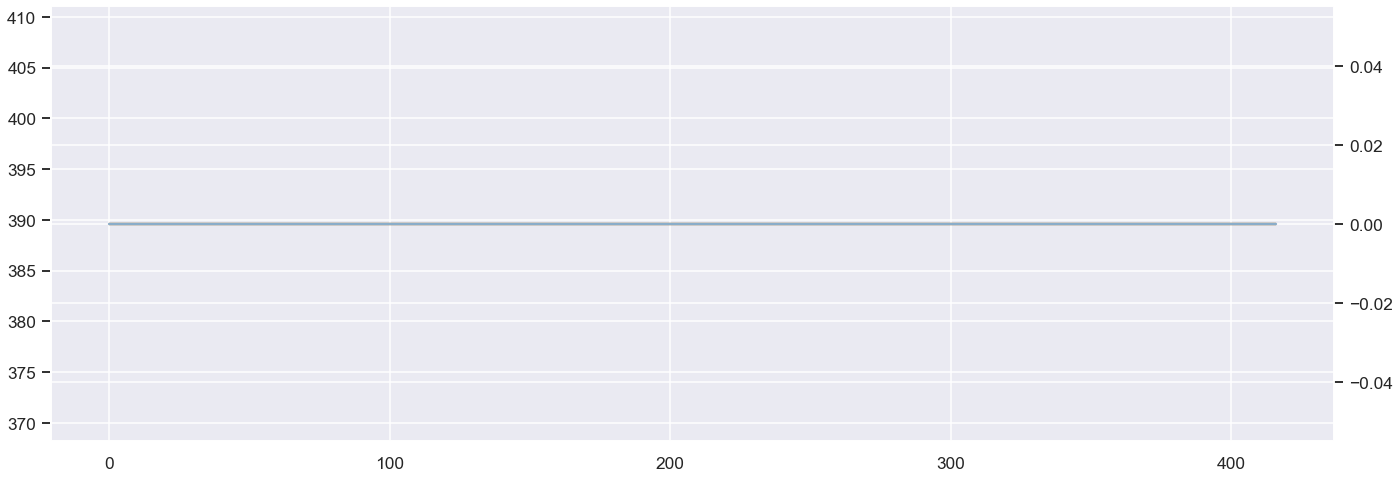

In [258]:
n_pts = 400
fig, ax1 = plt.subplots(figsize=(23,8))
ax2 = ax1.twinx()
ax1.plot(costs[::len(costs)//n_pts], 'r-')
ax1.plot(best_costs[1::len(costs)//n_pts], 'g-',alpha=1)
ax2.plot(probs[::len(costs)//n_pts], 'b-',alpha=0.5)
plt.show()

# Hill Climbing with sorted start and solo_mut

In [259]:
path, c, costs, probs, best_costs = annealing(maxsteps=10000, debug=0, Tmax=0.001, α=1, start='sorted', neigh='solo_mut')
print([node.id for node in path])
c

[17, 10, 20, 18, 19, 11, 6, 16, 2, 12, 13, 7, 14, 8, 3, 5, 9, 21, 4, 1, 15]


360.3138963965425

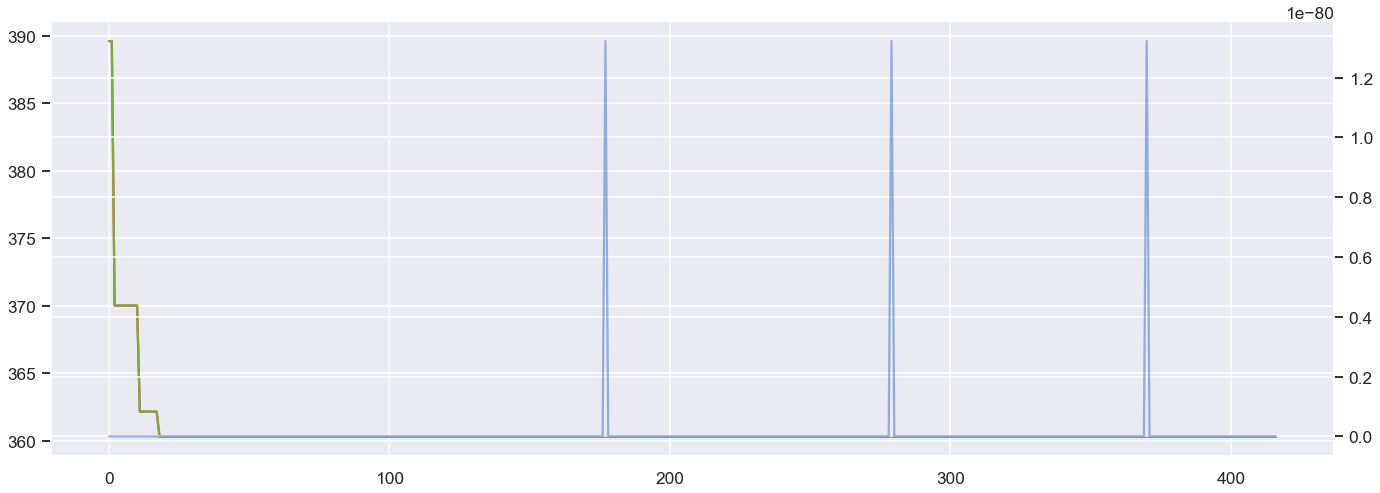

In [260]:
n_pts = 400
fig, ax1 = plt.subplots(figsize=(23,8))
ax2 = ax1.twinx()
ax1.plot(costs[::len(costs)//n_pts], 'r-')
ax1.plot(best_costs[1::len(costs)//n_pts], 'g-',alpha=1)
ax2.plot(probs[::len(costs)//n_pts], 'b-',alpha=0.5)
plt.show()

# Simulated annealing

In [261]:
path, c, costs, probs, best_costs = annealing(maxsteps=10000, debug=0, Tmax=100, α=1, start='sorted', neigh='solo_mut')
print([node.id for node in path])
c

[17, 20, 10, 18, 16, 2, 6, 12, 11, 13, 19, 7, 14, 8, 3, 5, 1, 9, 21, 4, 15]


454.9125890601587

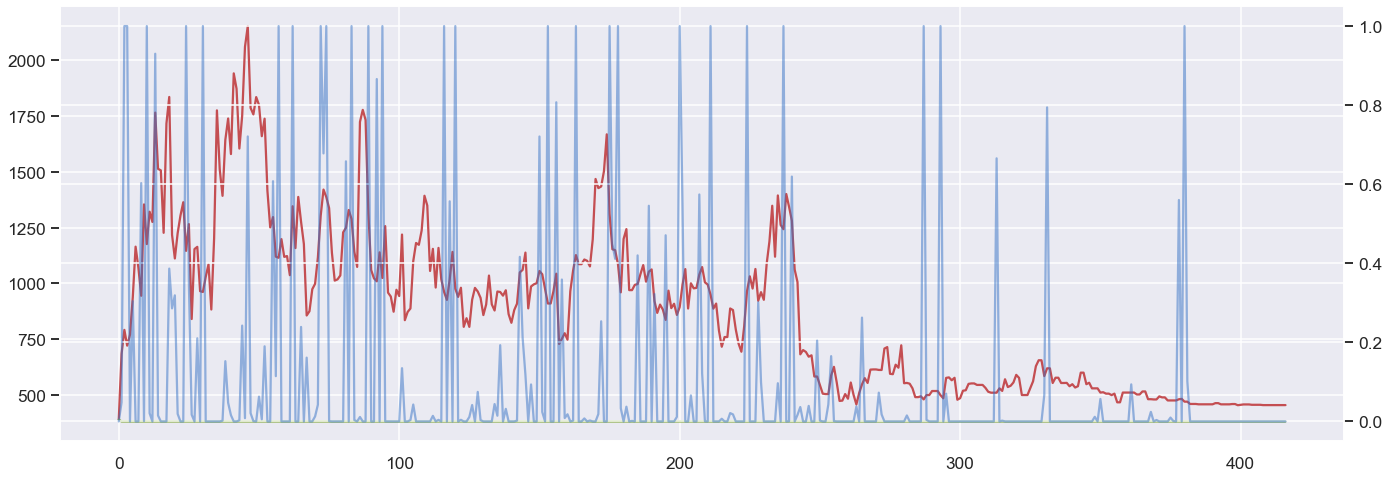

In [262]:
n_pts = 400
fig, ax1 = plt.subplots(figsize=(23,8))
ax2 = ax1.twinx()
ax1.plot(costs[::len(costs)//n_pts], 'r-')
ax1.plot(best_costs[1::len(costs)//n_pts], 'g-',alpha=1)
ax2.plot(probs[::len(costs)//n_pts], 'b-',alpha=0.5)
plt.show()

# Random starts

# Simulated annealing with custom mutation

In [263]:
path, c, costs, probs, best_costs = annealing(maxsteps=10000, debug=0, Tmax=500, α=1, start='random', neigh='mutation')
print([node.id for node in path])
c

[18, 16, 19, 13, 6, 2, 20, 10, 11, 12, 14, 5, 17, 7, 9, 4, 21, 8, 15, 3, 1]


1518.589551626323

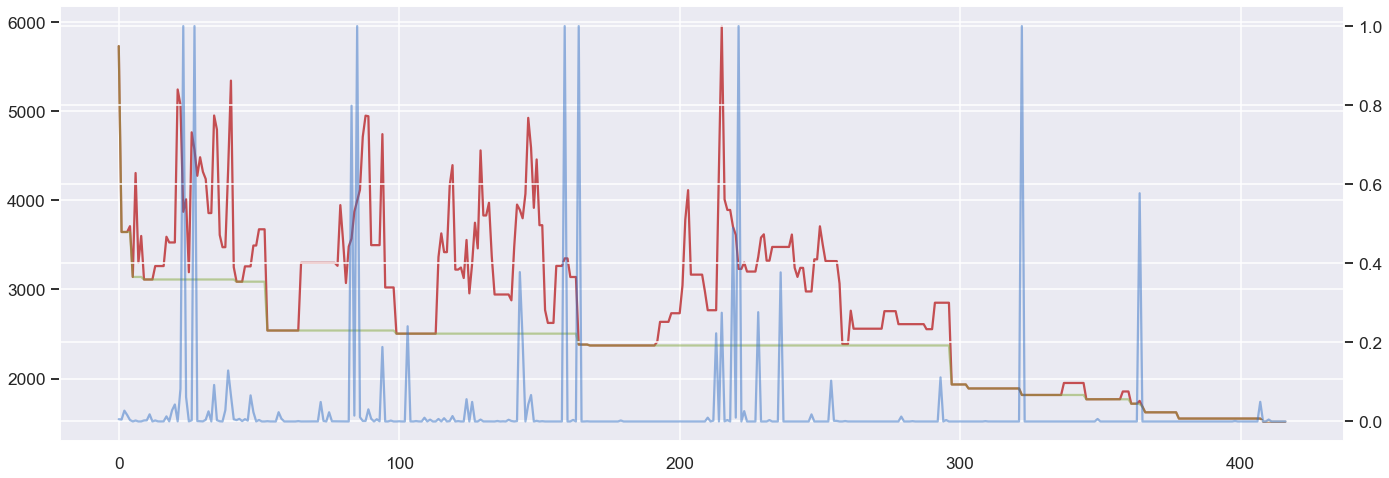

In [264]:
n_pts = 400
fig, ax1 = plt.subplots(figsize=(23,8))
ax2 = ax1.twinx()
ax1.plot(costs[::len(costs)//n_pts], 'r-')
ax1.plot(best_costs[1::len(costs)//n_pts], 'g-',alpha=0.5)
ax2.plot(probs[::len(costs)//n_pts], 'b-',alpha=0.5)
plt.show()

# Simulated annealing with random shuffling

In [265]:
path, c, costs, probs, best_costs = annealing(maxsteps=10000, debug=0, Tmax=1000, α=1, start='random', neigh='random')
print([node.id for node in path])
c

[17, 11, 16, 6, 2, 13, 7, 12, 18, 19, 3, 8, 5, 4, 1, 14, 9, 15, 20, 21, 10]


2384.858284442569

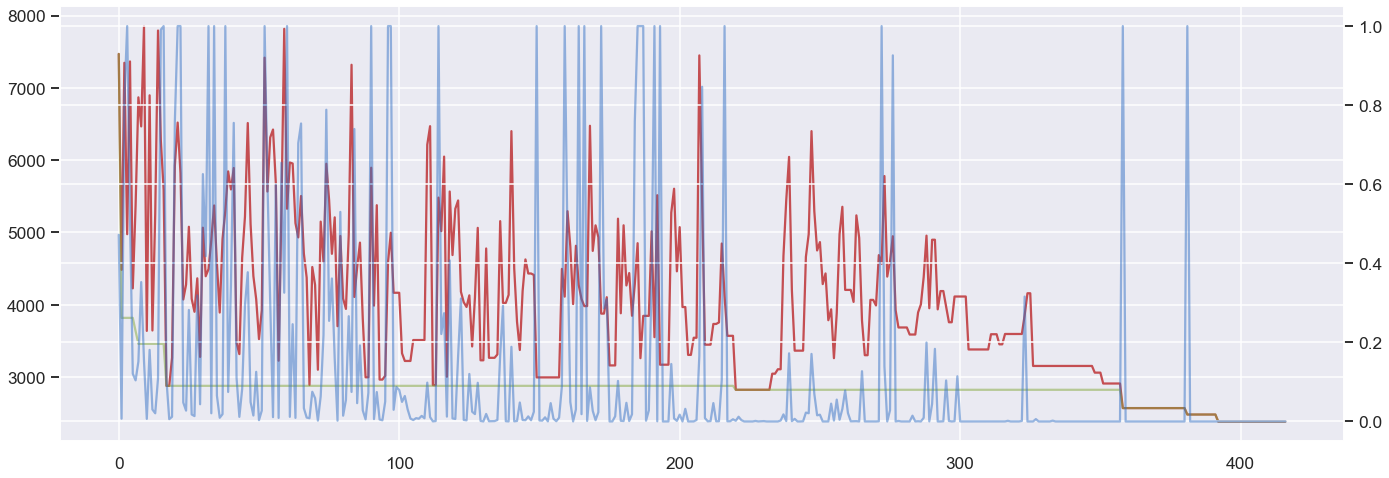

In [266]:
n_pts = 400
fig, ax1 = plt.subplots(figsize=(23,8))
ax2 = ax1.twinx()
ax1.plot(costs[::len(costs)//n_pts], 'r-')
ax1.plot(best_costs[1::len(costs)//n_pts], 'g-',alpha=0.5)
ax2.plot(probs[::len(costs)//n_pts], 'b-',alpha=0.5)
plt.show()

# Simulated annealing with solo_mut

In [267]:
path, c, costs, probs, best_costs = annealing(maxsteps=10000, debug=0, Tmax=100, α=1, start='random', neigh='solo_mut')
print([node.id for node in path])
c

[17, 10, 20, 18, 19, 2, 6, 12, 11, 13, 7, 14, 8, 3, 16, 5, 1, 9, 21, 4, 15]


536.2642388450512

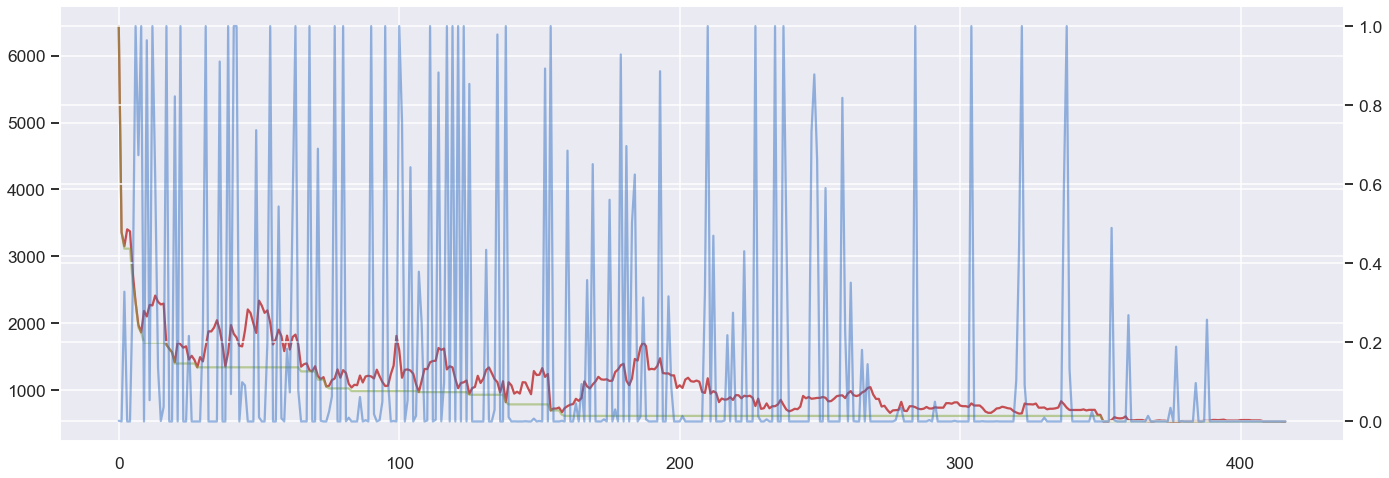

In [268]:
n_pts = 400
fig, ax1 = plt.subplots(figsize=(23,8))
ax2 = ax1.twinx()
ax1.plot(costs[::len(costs)//n_pts], 'r-')
ax1.plot(best_costs[1::len(costs)//n_pts], 'g-',alpha=0.5)
ax2.plot(probs[::len(costs)//n_pts], 'b-',alpha=0.5)
plt.show()

# Hill Climbing with random shuffle

In [269]:
path, c, costs, probs, best_costs = annealing(maxsteps=10000, debug=0, Tmax=0.001, α=1, start='random', neigh='random')
print([node.id for node in path])
c

[16, 2, 20, 13, 12, 19, 18, 10, 7, 9, 11, 6, 3, 8, 14, 5, 4, 21, 1, 17, 15]


2345.871632805913

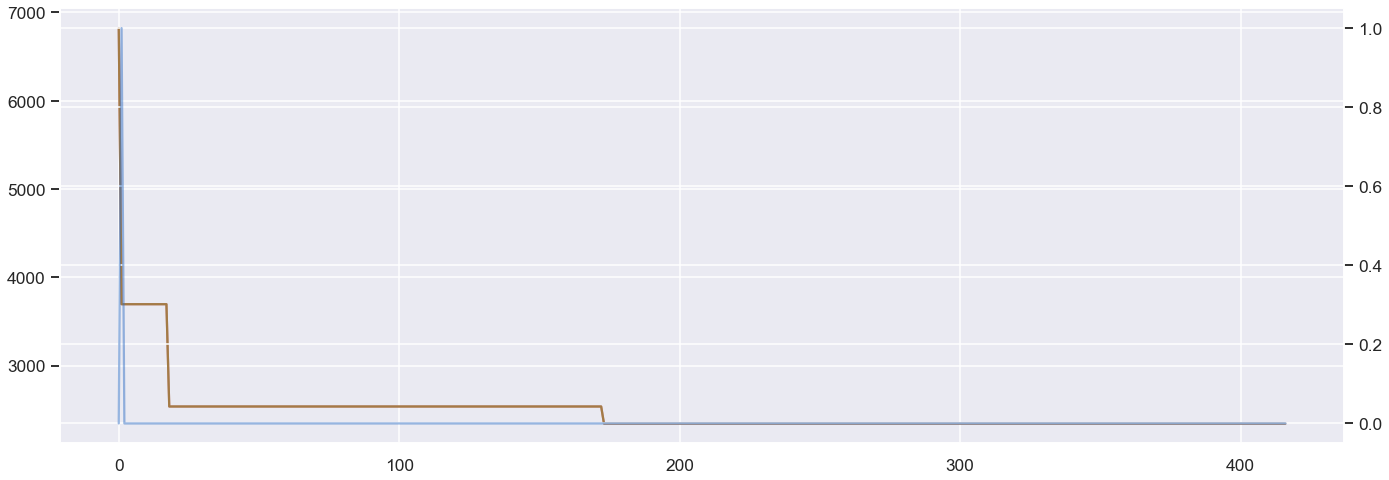

In [270]:
n_pts = 400
fig, ax1 = plt.subplots(figsize=(23,8))
ax2 = ax1.twinx()
ax1.plot(costs[::len(costs)//n_pts], 'r-')
ax1.plot(best_costs[1::len(costs)//n_pts], 'g-',alpha=0.5)
ax2.plot(probs[::len(costs)//n_pts], 'b-',alpha=0.5)
plt.show()

# Hill Climbing with solo_mut

In [271]:
path, c, costs, probs, best_costs = annealing(maxsteps=10000, debug=0, Tmax=0.001, α=1, start='random', neigh='solo_mut')
print([node.id for node in path])
c

[17, 10, 20, 18, 16, 2, 6, 11, 13, 19, 14, 8, 3, 5, 7, 12, 9, 21, 4, 1, 15]


700.9522223190977

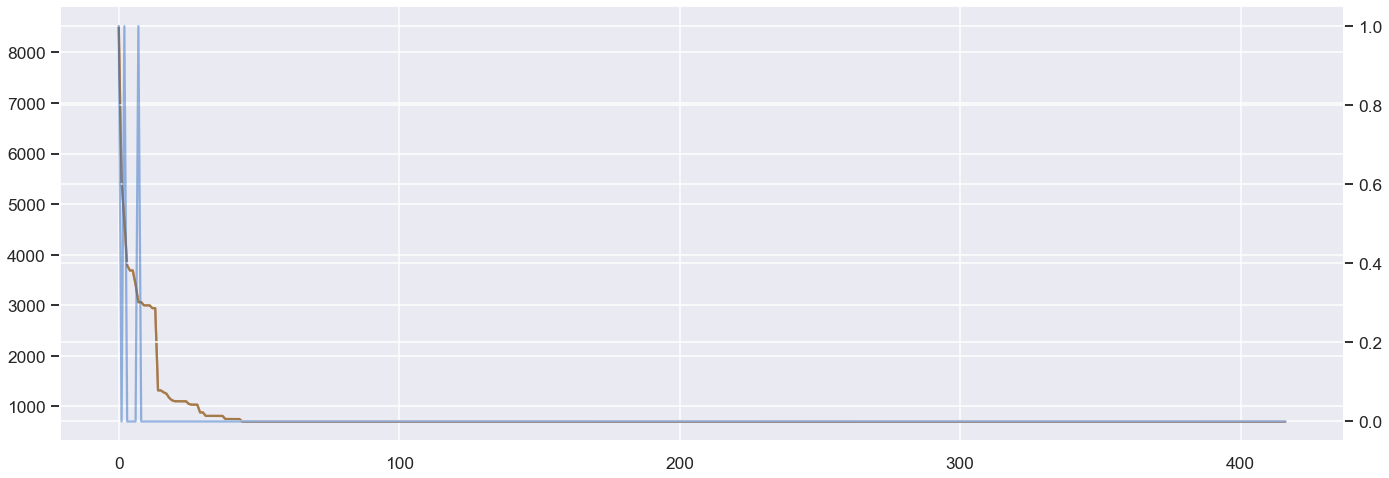

In [272]:
n_pts = 400
fig, ax1 = plt.subplots(figsize=(23,8))
ax2 = ax1.twinx()
ax1.plot(costs[::len(costs)//n_pts], 'r-')
ax1.plot(best_costs[1::len(costs)//n_pts], 'g-',alpha=0.5)
ax2.plot(probs[::len(costs)//n_pts], 'b-',alpha=0.5)
plt.show()

# Hill Climbing with custom mutation

In [273]:
path, c, costs, probs, best_costs = annealing(maxsteps=10000, debug=0, Tmax=0.001, α=1, start='random', neigh='mutation')
print([node.id for node in path])
c

[20, 16, 11, 18, 6, 17, 12, 10, 13, 7, 19, 1, 9, 2, 3, 8, 5, 21, 4, 15, 14]


1895.9987207999404

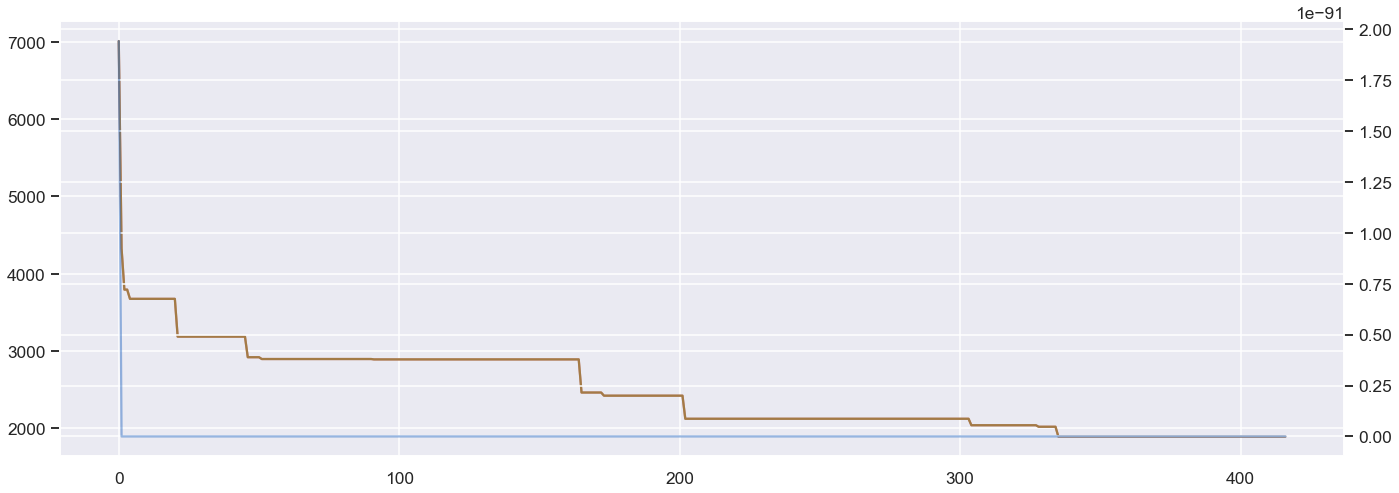

In [274]:
n_pts = 400
fig, ax1 = plt.subplots(figsize=(23,8))
ax2 = ax1.twinx()
ax1.plot(costs[::len(costs)//n_pts], 'r-')
ax1.plot(best_costs[1::len(costs)//n_pts], 'g-',alpha=0.5)
ax2.plot(probs[::len(costs)//n_pts], 'b-',alpha=0.5)
plt.show()

# One iteration

In [ ]:
path, c, costs, probs, best_costs = annealing(maxsteps=10000, debug=0, Tmax=0.001, α=1, start='random', neigh='mutation')
print([node.id for node in path])
c

In [ ]:
n_pts = 400
fig, ax1 = plt.subplots(figsize=(23,8))
ax2 = ax1.twinx()
ax1.plot(costs[::len(costs)//n_pts], 'r-')
ax1.plot(best_costs[1::len(costs)//n_pts], 'g-',alpha=1)
ax2.plot(probs[::len(costs)//n_pts], 'b-',alpha=0.5)
plt.show()

# Best of many iterations 
(you can stop kernel at any time the best one stay saved)

In [ ]:
best = annealing(maxsteps=10000, debug=0, Tmax=0.001, α=1, start='random', neigh='mutation')

In [ ]:
for _ in range(100):
    path, c, costs, probs, best_costs = annealing(maxsteps=10000, debug=0, Tmax=0.001, α=1, start='random', neigh='mutation')
    if c < best[1]:
        best = path, c, costs, probs, best_costs
    print([node.id for node in path])
    print(c)
path, c, costs, probs, best_costs = best 

In [ ]:
path, c, costs, probs, best_costs = best

In [ ]:
n_pts = 400
fig, ax1 = plt.subplots(figsize=(23,8))
ax2 = ax1.twinx()
ax1.plot(costs[::len(costs)//n_pts], 'r-')
ax1.plot(best_costs[1::len(costs)//n_pts], 'g-',alpha=1)
ax2.plot(probs[::len(costs)//n_pts], 'b-',alpha=0.5)
plt.show()

# Find served nodes in time 

In [ ]:
print(cost_function(path))
print([node.served_time - node.dt for node in path])
sum([1 if node.served_time - node.dt<=0 else 0 for node in path])

# Testing a text solution

In [ ]:
def test_sol(txt):
    l = txt.split()
    l = [int(e) for e in l]
    path=[]
    for i in l:
        path.append(list_nodes[i-1])
    return cost_function(path)
test_sol('1 17 10 20 18 19 11 6 16 2 12 13 7 14 8 3 5 9 21 4 15')